In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import os
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import Huber
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


In [11]:
def load_data(directory):
    X, y = [], []
    for root, _, files in os.walk(directory):
        print(f'Processing directory: {root}')
        print(f'Files: {files}')
        for file in files:
            if file.endswith('_emg.npy'):
                info_file = os.path.join(root, file.replace('_emg.npy', '_info.json'))
                emg_file = os.path.join(root, file)
                if os.path.exists(info_file):
                    with open(info_file, 'r') as f:
                        info = json.load(f)
                        sentence_index = info.get('sentence_index', -1)
                        if sentence_index != -1:
                            emg = np.load(emg_file)
                            X.append(emg)
                            y.append(sentence_index)
    return X, y

# Load data
directory = '/content/drive/MyDrive/silent_parallel_data/silent_sort'


In [4]:
X, y = load_data(directory)

# Pad sequences to ensure uniform length
X = pad_sequences(X, padding='post')

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape X_train and X_test
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# Apply MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

# Reshape data back to original 3D form
X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

# Define the model
model = Sequential()

# Add Conv1D layers
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.01)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D(pool_size=2))

# Add another block of Conv1D layers
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Conv1D(filters=512, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D(pool_size=2))

# Add LSTM layers
model.add(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(LSTM(128, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

# Add output layer
num_classes = max(y) + 1
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy', MeanSquaredError(), MeanAbsoluteError()]
)

# Train the model
history = model.fit(np.array(X_train_scaled), np.array(y_train), epochs=10,
                    validation_data=(np.array(X_test_scaled), np.array(y_test)), batch_size=16, verbose=1)



Epoch 1/10
11/11 [==============================] - 1086s 97s/step - loss: 21.3831 - accuracy: 0.0000e+00 - mean_squared_error: 1015505.6875 - mean_absolute_error: 1005.8834 - val_loss: 18.0662 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1012612.9375 - val_mean_absolute_error: 1003.9995
Epoch 2/10
11/11 [==============================] - 1047s 96s/step - loss: 15.9448 - accuracy: 0.0058 - mean_squared_error: 1015505.6875 - mean_absolute_error: 1005.8831 - val_loss: 13.9063 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1012612.8125 - val_mean_absolute_error: 1003.9993
Epoch 3/10
11/11 [==============================] - 1044s 96s/step - loss: 12.0056 - accuracy: 0.0058 - mean_squared_error: 1015505.6875 - mean_absolute_error: 1005.8828 - val_loss: 11.5954 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1012612.9375 - val_mean_absolute_error: 1003.9993
Epoch 4/10
11/11 [==============================] - 1054s 96s/step - loss: 9.1682 - accuracy: 0.0058 - mean_squared_e

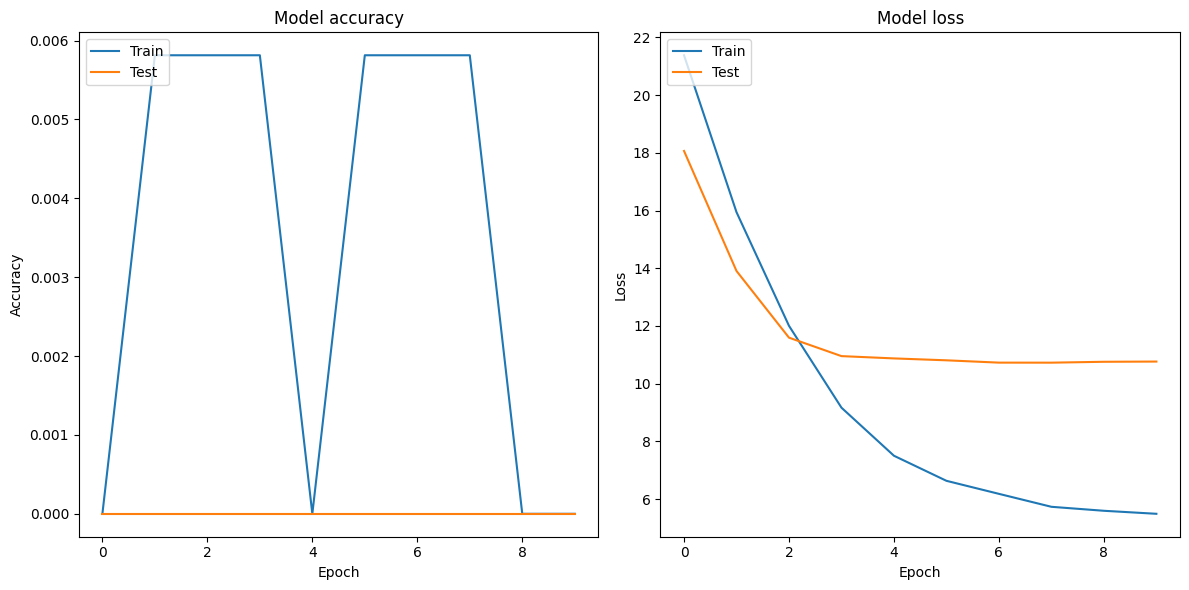

In [5]:
# Plot accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()


In [6]:
# Оценка модели
loss, accuracy, mse, mae = model.evaluate(np.array(X_test_scaled), np.array(y_test), verbose=0)
print(f'Test loss: {loss:.3f}')
print(f'Test accuracy: {accuracy:.3f}')
print(f'Test MSE: {mse:.3f}')
print(f'Test MAE: {mae:.3f}')

# Calculate predictions for the test set
y_pred = model.predict(np.array(X_test_scaled))
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate RMSE
rmse = np.sqrt(np.mean((np.array(y_test) - y_pred_classes) ** 2))
print(f'Test RMSE: {rmse:.3f}')

# Calculate Huber Loss
huber_loss = Huber()
huber_loss_value = huber_loss(np.array(y_test), y_pred_classes).numpy()
print(f'Test Huber Loss: {huber_loss_value:.3f}')


Test loss: 10.767
Test accuracy: 0.000
Test MSE: 1012612.750
Test MAE: 1003.999
2/2 [==============================] - 53s 16s/step
Test RMSE: 84.253
Test Huber Loss: 72.000


In [7]:
# Делаем прогноз
prediction = model.predict(np.array([X_test[0]]))
predicted_class = np.argmax(prediction)
print(f'Predicted class: {predicted_class}')


1/1 [==============================] - 6s 6s/step
Predicted class: 1054


In [8]:
# Saving the model
model.save('/content/drive/MyDrive/ProjectDataset_h2/emg_model_open_source.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
# Upload the model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/ProjectDataset_h2/emg_model_open_source.h5')


In [10]:
# Convert to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter.experimental_new_converter = True
converter.experimental_new_quantizer = True
converter.experimental_new_quantizer_debug = True

tflite_model = converter.convert()

# Save to TensorFlow Lite in file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)